In [74]:
import tensorflow as tf
import keras
import numpy as np
import os
import json
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
train_image_folder = '/raid/mpsych/OMAMA/DATA/data/train'
train_npz_folder = '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512'
# train_npz_folder = '/raid/mpsych/OMAMA/DATA/data/2d_resized_512/images'

In [3]:
# Get lists of image and npz files
image_files = [os.path.join(train_image_folder, f) for f in os.listdir(train_image_folder) if f.endswith('.png')]
npz_files = [os.path.join(train_npz_folder, f) for f in os.listdir(train_npz_folder) if f.endswith('.npz')]

In [4]:
image_files = image_files[:99999]

In [5]:
len(image_files)

99999

In [6]:
npz_files = npz_files[:99999]

In [6]:
len(npz_files)

130615

In [7]:
# Split the dataset (adjust the test_size as needed)
train_files, test_files = train_test_split(list(zip(image_files, npz_files)), test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

In [8]:
# Print the counts
print("Train set:")
print(f"Number of image files in train: {sum(1 for file in train_files if file[0].endswith('.png'))}")
print(f"Number of npz files in train: {sum(1 for file in train_files if file[1].endswith('.npz'))}")

print("\nValidation set:")
print(f"Number of image files in validation: {sum(1 for file in val_files if file[0].endswith('.png'))}")
print(f"Number of npz files in validation: {sum(1 for file in val_files if file[1].endswith('.npz'))}")

print("\nTest set:")
print(f"Number of image files in test: {sum(1 for file in test_files if file[0].endswith('.png'))}")
print(f"Number of npz files in test: {sum(1 for file in test_files if file[1].endswith('.npz'))}")

Train set:
Number of image files in train: 69999
Number of npz files in train: 69999

Validation set:
Number of image files in validation: 15000
Number of npz files in validation: 15000

Test set:
Number of image files in test: 15000
Number of npz files in test: 15000


In [23]:
# Assuming you have defined train_files, val_files, and test_files as shown in your code

# Print the first 5 files in the training set
print("First 5 files in the training set:")
for i in range(5):
    print(train_files[i])

# Print the first 5 files in the validation set
print("\nFirst 5 files in the validation set:")
for i in range(5):
    print(val_files[i])

# Print the first 5 files in the test set
print("\nFirst 5 files in the test set:")
for i in range(5):
    print(test_files[i])
    
def print_raw_data(npz_file):
    data = np.load(npz_file)
    for key in data.files:
        print(f"Data in '{key}':")
        print(data[key])

# Print raw data for the first 5 files in the training set
print("\nRaw data in the training set:")
for i in range(5):
    print(f"\nFile {i + 1}:")
    print_raw_data(train_files[i][1])


First 5 files in the training set:
('/raid/mpsych/OMAMA/DATA/data/train/sample_60847.png', '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512/10195895820725132694762818055891556958.npz')
('/raid/mpsych/OMAMA/DATA/data/train/sample_28616.png', '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512/14822510414339837774385799152326406139.npz')
('/raid/mpsych/OMAMA/DATA/data/train/sample_9902.png', '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512/117662734601567944015951467842055389706.npz')
('/raid/mpsych/OMAMA/DATA/data/train/sample_14063.png', '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512/100277230214392662382344089241296395354.npz')
('/raid/mpsych/OMAMA/DATA/data/train/sample_9000.png', '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512/23497914542737440734565006330973151527.npz')

First 5 files in the validation set:
('/raid/mpsych/OMAMA/DATA/data/train/sample_76798.png', '/raid/mpsych/OMAMA/DATA/data/adjusted_2d_512/118153616021036566415723530971480796721.npz')
('/raid/mpsych/OMAMA/DATA/data/train/sample_

In [10]:
img_height = 512
img_width = 512
batch_size = 32

In [57]:
def custom_data_generator(file_list, batch_size, img_height, img_width):
    total_files = len(file_list)
    indices = np.arange(total_files)
    
    while True:
        np.random.shuffle(indices)
        
        for i in range(0, total_files, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                img_file, npz_file = file_list[idx]

                # Process image file
                image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (img_width, img_height))
                image = np.expand_dims(image, axis=-1)
                image = image/255
                batch_images.append(image)
                batch_labels.append(1)

                # Process npz file
                with np.load(npz_file, allow_pickle=True) as data:
                    npz = data['data']
                npz = np.expand_dims(npz, axis=-1)   
                
#                 print("before:")
#                 print(npz.min(),npz.max())
               
#                 if npz.max() != npz.min():
#                     npz = (npz - npz.min()) / (npz.max() - npz.min())
#                 else:
#                     npz = npz / (npz.max()+ 1e-7)
                    
#                 print("after :")
#                 print(npz.min(),npz.max())
 
                batch_images.append(npz)
                batch_labels.append(0)
        
                     
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=2)  # two classes (0 for npz, 1 for png)
            
            indices_within_batch = np.arange(len(batch_labels))
            np.random.shuffle(indices_within_batch)

            yield batch_images[indices_within_batch], batch_labels[indices_within_batch]

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min')

In [59]:
NUMBER_OF_CLASSES = 2

In [60]:
# Create data generators
train_generator = custom_data_generator(train_files, batch_size, img_height, img_width)
val_generator = custom_data_generator(val_files, batch_size, img_height, img_width)
test_generator = custom_data_generator(test_files, batch_size, img_height, img_width)


In [65]:
# Modify the model for deeper architecture
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Additional Convolutional layers
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# Flatten and Dense layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 510, 510, 32)      320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 508, 508, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 254, 254, 64)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 254, 254, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 252, 252, 128)     73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 126, 126, 128)     0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 126, 126, 128)    

In [75]:
adam_optimizer = Adam(learning_rate=0.001)

In [76]:

model.compile(loss=categorical_crossentropy,
              optimizer=adam_optimizer,
              metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7faee00f0c10>

In [51]:
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=3,
        validation_data=val_generator,
        validation_steps= 100,
        verbose=1,
        callbacks=[early_stopping]
    )
except Exception as e:
    print("An error occurred during training:", str(e))

Epoch 1/3
223/300 [=====================>........] - ETA: 39s - loss: 0.3658 - accuracy: 0.9174

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_files) // batch_size)
print(f"Test Accuracy: {test_accuracy}")

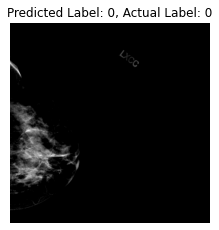

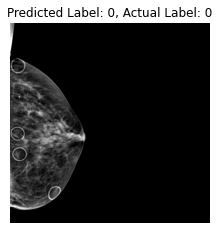

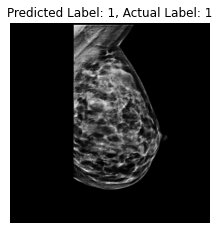

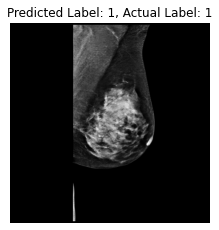

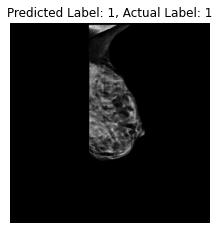

In [45]:
for i in range(5):
    test_sample, test_labels = next(test_generator)
    predictions = model.predict(test_sample)

    # Display the predicted label
    plt.subplot(1, 2, 2)
    predicted_label = np.argmax(predictions[i])
    actual_label = np.argmax(test_labels[i])
    plt.title(f"Predicted Label: {predicted_label}, Actual Label: {actual_label}")
    plt.imshow(test_sample[i], cmap='gray') 
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# 1 for Synthetic and 0 for original

In [46]:
predictions = model.predict(test_generator, steps=len(test_files) // batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

468/468 [==============================] - 154s 328ms/step


In [47]:
predicted_labels

array([0, 1, 0, ..., 1, 1, 0])

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

true_labels_all = []
for _ in range(len(test_files) // batch_size):
    _, batch_labels_all = next(test_generator)
    true_labels_all.extend(np.argmax(batch_labels_all, axis=1))

print("True Label Distribution:", np.bincount(true_labels_all))
print("Predicted Label Distribution:", np.bincount(predicted_labels))

# Print confusion matrix and classification report
cm = confusion_matrix(true_labels_all, predicted_labels)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(true_labels_all, predicted_labels))


True Label Distribution: [14968 14968]
Predicted Label Distribution: [14972 14964]
Confusion Matrix:
[[7520 7448]
 [7452 7516]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     14968
           1       0.50      0.50      0.50     14968

    accuracy                           0.50     29936
   macro avg       0.50      0.50      0.50     29936
weighted avg       0.50      0.50      0.50     29936

